In [ ]:
import numpy as np
import pandas as pd
import nltk
import re
nltk.download('stopwords')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BERT_prediction = pd.read_csv("/content/drive/MyDrive/Amazon_Unseen_Predictions_BERT_v2.csv") # Reading BERT data based on code from Amazon_BERT

BERT_prediction['Srn'] = np.arange(BERT_prediction.shape[0]) #Adding an extra column which would act as an ID

LSTM_CNN_prediction = pd.read_csv("/content/drive/MyDrive/Prediction_LSTM_CNN.csv") # Reading CNN/LSTM data based on code from Amazon_DL Code


In [ ]:

LSTM_CNN_prediction.shape [0] == BERT_prediction.shape[0] #Validate whether the rows matches

True

In [ ]:
#Considering columns in-scope
LSTM_CNN_prediction = LSTM_CNN_prediction[['Srn','Predicted Sentiments_cnn','cnn_vs_actual','Predicted Sentiments_lstm','lstm_vs_actual']] 

BERT_prediction = BERT_prediction[['Srn','name','primaryCategories', 'manufacturer','asins','reviews.rating','reviews.numHelpful','BERT_sentiment','Amazon_rating','BERT_vs_actual','reviews.text','reviews.title']]


In [ ]:
#Data merge
BERT_LSTM_CNN_prediction = pd.merge(LSTM_CNN_prediction,BERT_prediction,on='Srn')

BERT_LSTM_CNN_prediction.to_csv("./drive/MyDrive/BERT_LSTM_CNN_prediction.csv", sep=',', encoding='UTF-8')

BERT_LSTM_CNN_prediction.head(5)

,Srn,Predicted Sentiments_cnn,cnn_vs_actual,Predicted Sentiments_lstm,lstm_vs_actual,name,primaryCategories,manufacturer,asins,reviews.rating,reviews.numHelpful,BERT_sentiment,Amazon_rating,BERT_vs_actual,reviews.text,reviews.title
0,0,0.5,False,0.1,False,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,AmazonBasics,"B00QWO9P0O,B00LH3DMUO",3,NaN,0.0,1,False,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...
1,1,4.9,True,5.0,True,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,AmazonBasics,"B00QWO9P0O,B00LH3DMUO",4,NaN,1.0,1,True,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...
2,2,5.0,True,5.0,True,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,AmazonBasics,"B00QWO9P0O,B00LH3DMUO",5,NaN,1.0,1,True,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...
3,3,5.0,True,5.0,True,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,AmazonBasics,"B00QWO9P0O,B00LH3DMUO",5,NaN,1.0,1,True,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...
4,4,5.0,True,5.0,True,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,AmazonBasics,"B00QWO9P0O,B00LH3DMUO",5,NaN,1.0,1,True,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...


<Axes: xlabel='Sentiment', ylabel='count'>

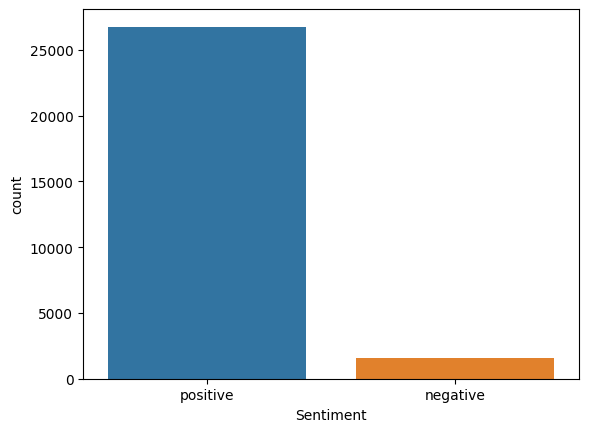

In [ ]:
BERT_LSTM_CNN_prediction['Sentiment'] = BERT_LSTM_CNN_prediction['reviews.rating'].apply(lambda x: 'positive' if x >=3  else 'negative')

#distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='Sentiment', data=BERT_LSTM_CNN_prediction)

# Pre-processing

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # Removing single character after apostophe.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  #Single characters are replace  by a space and further the multiple spaces are removed

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence


In [ ]:
reviews_processed = []
unseen_reviews = BERT_LSTM_CNN_prediction['reviews.text']

for review in unseen_reviews:
  review = preprocess_text(review)
  reviews_processed.append(review)

BERT_LSTM_CNN_prediction['reviews.numHelpful'] = BERT_LSTM_CNN_prediction['reviews.numHelpful'].fillna(0)

BERT_LSTM_CNN_prediction['reviews.processed'] = reviews_processed



In [ ]:
BERT_LSTM_CNN_prediction_positive = BERT_LSTM_CNN_prediction[BERT_LSTM_CNN_prediction['BERT_sentiment'] == 1]
BERT_LSTM_CNN_prediction_negative = BERT_LSTM_CNN_prediction[BERT_LSTM_CNN_prediction['BERT_sentiment'] != 1]


In [ ]:
#Positive
BERT_LSTM_CNN_prediction_positive['temp_list'] = BERT_LSTM_CNN_prediction_positive['reviews.processed'].apply(lambda x:str(x).split())
top = Counter([item for sublist in BERT_LSTM_CNN_prediction_positive['temp_list'] for item in sublist ])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

<ipython-input-15-67705ff2cbbd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BERT_LSTM_CNN_prediction_positive['temp_list'] = BERT_LSTM_CNN_prediction_positive['reviews.processed'].apply(lambda x:str(x).split())


,Common_words,count
0,great,9368
1,batteries,6903
2,tablet,6504
3,good,5745
4,price,5122
5,use,4245
6,amazon,3577
7,love,3516
8,bought,2979
9,easy,2933


In [ ]:
#Positive
BERT_LSTM_CNN_prediction_negative['temp_list'] = BERT_LSTM_CNN_prediction_negative['reviews.processed'].apply(lambda x:str(x).split())
top = Counter([item for sublist in BERT_LSTM_CNN_prediction_negative['temp_list'] for item in sublist ])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

<ipython-input-19-dc5de34576d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BERT_LSTM_CNN_prediction_negative['temp_list'] = BERT_LSTM_CNN_prediction_negative['reviews.processed'].apply(lambda x:str(x).split())


,Common_words,count
0,batteries,1245
1,last,437
2,amazon,341
3,battery,297
4,long,248
5,use,239
6,buy,233
7,one,221
8,work,220
9,bought,207


# Rating mis-match

In [ ]:
#vaders[vaders['BERT_sentiment'] == 1.0 | vaders[vaders['pos'] >= 0.5] ]

#vaders[(vaders.BERT_sentiment == 1) & (vaders.pos >= 0.5) & (vaders.Amazon_rating != 1) ]

In [ ]:
# True Negative/Positive cases

vaders_sentiment_comparison = vaders.loc[(vaders['Amazon_rating'] == 1) 
                                          #& (vaders['BERT_vs_actual'] == False) | (vaders['lstm_vs_actual'] == False) | (vaders['cnn_vs_actual'] == False))
                                            ,['cnn_vs_actual','lstm_vs_actual','BERT_vs_actual']]

vaders_sentiment_comparison.groupby(['cnn_vs_actual','lstm_vs_actual','BERT_vs_actual']).size().reset_index(name='count')


,cnn_vs_actual,lstm_vs_actual,BERT_vs_actual,count
0,False,False,False,123
1,False,False,True,363
2,False,True,False,63
3,False,True,True,806
4,True,False,False,69
5,True,False,True,437
6,True,True,False,244
7,True,True,True,24646


In [ ]:
# False Negative/Positive cases

vaders_sentiment_comparison = vaders.loc[(vaders['Amazon_rating'] != 1 )
                                          #& (vaders['BERT_vs_actual'] == True) | (vaders['lstm_vs_actual'] == True) | (vaders['cnn_vs_actual'] == True))
                                            ,['cnn_vs_actual','lstm_vs_actual','BERT_vs_actual']]

vaders_sentiment_comparison.groupby(['cnn_vs_actual','lstm_vs_actual','BERT_vs_actual']).size().reset_index(name='count')


,cnn_vs_actual,lstm_vs_actual,BERT_vs_actual,count
0,False,False,False,232
1,False,False,True,215
2,False,True,False,64
3,False,True,True,111
4,True,False,False,54
5,True,False,True,101
6,True,True,False,124
7,True,True,True,680


In [ ]:
vaders.to_csv("./drive/MyDrive/vaders_new.csv", sep=',', encoding='UTF-8')


# Using Vader to derive sentiment score

In [ ]:
sia = SentimentIntensityAnalyzer()

res = {}
for i, row in tqdm(BERT_LSTM_CNN_prediction.iterrows(), total=len(BERT_LSTM_CNN_prediction)):
    try:
      text = row['reviews.processed']
      myid = row['Srn']
      res[myid] = sia.polarity_scores(text)
    except:
      text = row['reviews.processed']
      myid = row['Srn']
      res[myid] = ""


  0%|          | 0/28332 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Srn'})
vaders = vaders.merge(BERT_LSTM_CNN_prediction, how='left')
vaders.head(5)

,Srn,neg,neu,pos,compound,Predicted Sentiments_cnn,cnn_vs_actual,Predicted Sentiments_lstm,lstm_vs_actual,name,...,asins,reviews.rating,reviews.numHelpful,BERT_sentiment,Amazon_rating,BERT_vs_actual,reviews.text,reviews.title,Sentiment,reviews.processed
0,0,0.322,0.678,0.000,-0.6908,0.5,False,0.1,False,AmazonBasics AAA Performance Alkaline Batterie...,...,"B00QWO9P0O,B00LH3DMUO",3,0.0,0.0,1,False,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,positive,order one item bad quality missing backup spri...
1,1,0.000,0.737,0.263,0.3612,4.9,True,5.0,True,AmazonBasics AAA Performance Alkaline Batterie...,...,"B00QWO9P0O,B00LH3DMUO",4,0.0,1.0,1,True,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,positive,bulk always less expensive way go products like
2,2,0.000,0.256,0.744,0.7003,5.0,True,5.0,True,AmazonBasics AAA Performance Alkaline Batterie...,...,"B00QWO9P0O,B00LH3DMUO",5,0.0,1.0,1,True,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,positive,well duracell price happy
3,3,0.000,0.583,0.417,0.6124,5.0,True,5.0,True,AmazonBasics AAA Performance Alkaline Batterie...,...,"B00QWO9P0O,B00LH3DMUO",5,0.0,1.0,1,True,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,positive,seem work well name brand batteries much bette...
4,4,0.000,0.494,0.506,0.6249,5.0,True,5.0,True,AmazonBasics AAA Performance Alkaline Batterie...,...,"B00QWO9P0O,B00LH3DMUO",5,0.0,1.0,1,True,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,positive,batteries long lasting price great


In [ ]:
vaders.to_csv("./drive/MyDrive/vaders_sentiment_1.csv", sep=',', encoding='UTF-8')


In [ ]:
review_positive = vaders[vaders['pos'] >= 0.5].copy()
review_negative = vaders[vaders['neg'] >= 0.5].copy()
